In [176]:
import pandas as pd
import numpy as np
import os
import sys
import gc
from sklearn.manifold import TSNE
from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import scipy 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import utils
reload(utils)

<module 'utils' from '/Users/milk/Desktop/git_repositories/READMISSIONS/washtenaw_case_study/notebooks/utils.py'>

In [177]:
matplotlib.rcParams['figure.dpi'] = 200
plt.style.use('seaborn-deep')

In [184]:
"""
Load all Washtenaw Country Images and features
"""

DATA_PATH = "../cleaned_data/clean_data.csv"
data_df = pd.read_csv(DATA_PATH)
data_df['TRACT'] = data_df['TRACT'].astype(str)
print(data_df.shape)

(5013, 4996)


In [185]:
"""
Load Ann Arbor 500 cities data
"""

CITIES_PATH = "../demographic_data/Ann_Arbor_500_Cities.csv"
cities_df = pd.read_csv(CITIES_PATH)
print(cities_df.shape)
cities_df = cities_df[cities_df['PlaceName'] == 'Ann Arbor']
print(f"Ann Arbor tracts: {cities_df.shape}")
cities_df['TRACT'] = cities_df['TractFIPS'].astype(str).str[-6:]

(27210, 63)
Ann Arbor tracts: (33, 63)


In [186]:
"""
filter the images to Ann Arbor
"""

data_df = data_df[data_df['TRACT'].isin(cities_df['TRACT'])]
print(data_df.shape)

CITIES_COLS = cities_df.columns.to_list()
data_df = pd.merge(data_df, cities_df, on='TRACT', how='left')
print(data_df.shape)

(208, 4996)
(208, 5059)


In [187]:
"""
a list of crude prevalences from 500 cities data
"""

ALL_LABEL_COLS = [x for x in data_df.columns if 'label' in x]
print(f"Number of Distinct Labels: {len(ALL_LABEL_COLS)}")

MANUAL_LABELS = [x.strip() for x in open("../image_data/manual_labels.txt")]
print(f"Number of Distinct Labels in curated list: {len(MANUAL_LABELS)}")

PREVALENCE = [x for x in CITIES_CO  LS if 'CrudePrev' in x]
print(f"Number prevalence columns: {len(PREVALENCE)}")

REDS = [x for x in data_df.columns if 'red_eig' in x]
BLUES = [x for x in data_df.columns if 'blue_eig' in x]
GREENS = [x for x in data_df.columns if 'green_eig' in x]

Number of Distinct Labels: 326
Number of Distinct Labels in curated list: 99
Number prevalence columns: 28


In [192]:
"""
Need to balance crude prevalance by the population
"""
# INCOME_COLUMNS = pd.read_csv("../cleaned_data/income_column_map.csv")
# INCOME_COLUMNS[INCOME_COLUMNS['id'].str.contains("Total")]
# data_df.columns.to_list()

['Abseiling_label',
 'Adaptation_label',
 'Adventure_label',
 'Aerial_photography_label',
 'Amusement_park_label',
 'Amusement_ride_label',
 'Ancient_rome_label',
 'Antique_label',
 'Apartment_label',
 'Arcade_label',
 'Arch_label',
 'Archaeological_site_label',
 'Architecture_label',
 'Arena_label',
 'Art_label',
 'Artifact_label',
 'Artwork_label',
 'Asphalt_label',
 'Atmospheric_phenomenon_label',
 'Automotive_tire_label',
 'Automotive_wheel_system_label',
 'Bamboo_label',
 'Bat_label',
 'Bathroom_sink_label',
 'Beam_label',
 'Beanie_label',
 'Beauty_label',
 'Bedrock_label',
 'Beige_label',
 'Birch_label',
 'Birch_family_label',
 'Bird_label',
 "Bird's-eye_view_label",
 'Birdhouse_label',
 'Black_label',
 'Black_cat_label',
 'Black-and-white_label',
 'Boombox_label',
 'Branch_label',
 'Brick_label',
 'Bridge_label',
 'Brown_label',
 'Building_label',
 'Bunker_label',
 'Camouflage_label',
 'Canidae_label',
 'Canoe_birch_label',
 'Canyon_label',
 'Cap_label',
 'Car_label',
 'Carving_

In [182]:
INCOME_COLUMNS = pd.read_csv("../cleaned_data/income_column_map.csv")
INCOME_COLUMNS.head()

,GEO_ID,id
0,NAME,Geographic Area Name
1,S1903_C01_001E,Total!!Estimate!!Households
2,S1903_C01_001M,Total!!Margin of Error!!Households
3,S1903_C01_002E,Total!!Estimate!!Households!!One race!!White
4,S1903_C01_002M,Total!!Margin of Error!!Households!!One race!!...


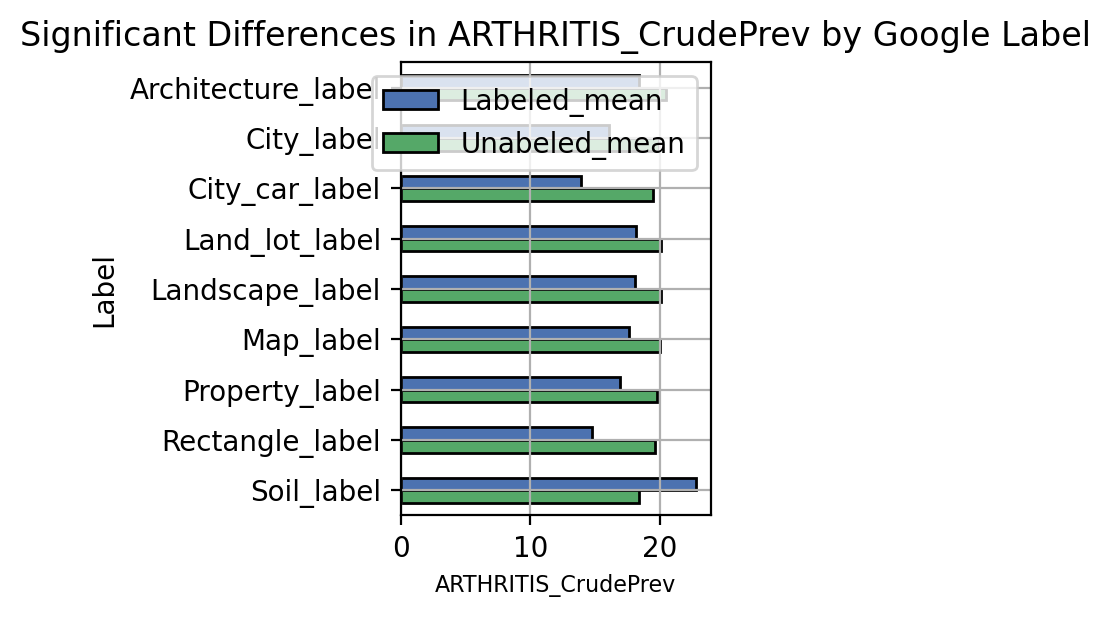

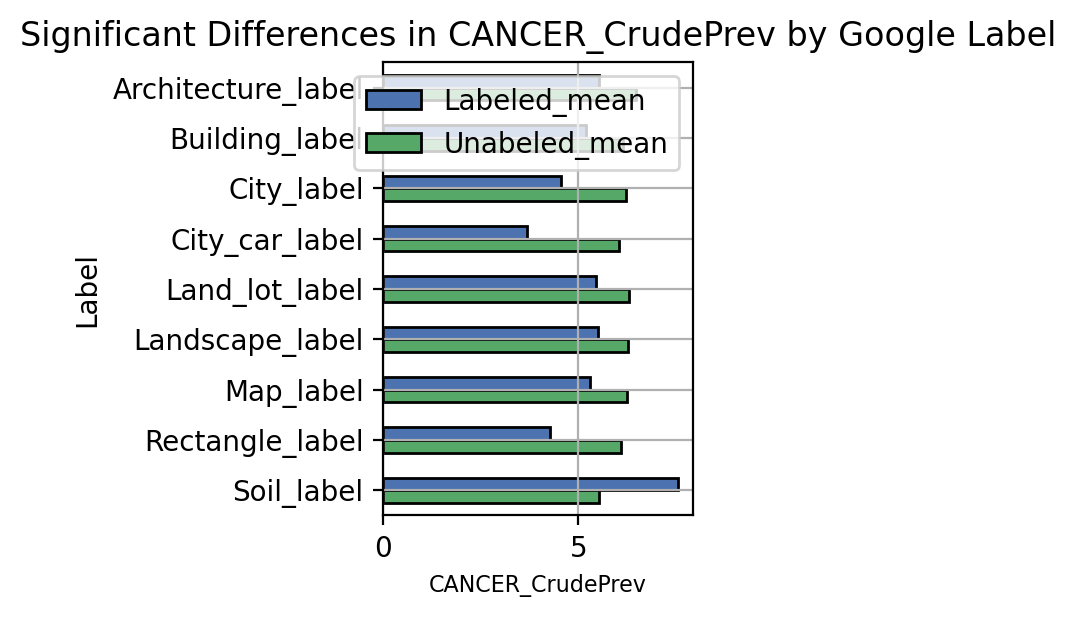

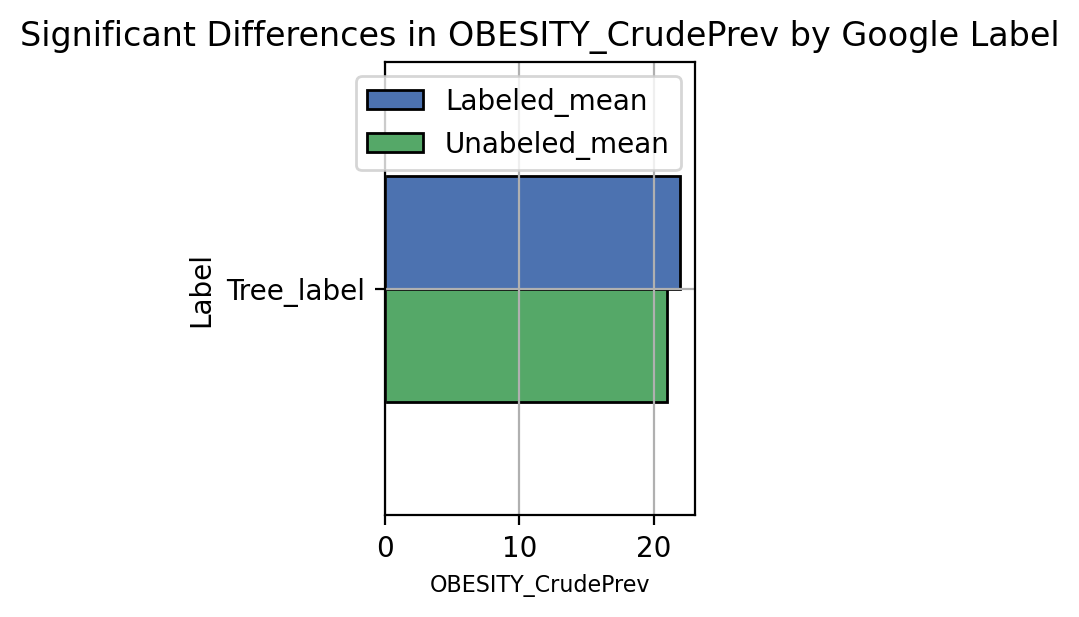

In [21]:
"""
Let's do tttest for each label 
"""

tmp = data_df.copy()

NAN_POLICY = 'omit'

for prev in ['ARTHRITIS_CrudePrev', 'CANCER_CrudePrev', 'OBESITY_CrudePrev']:
    TARGET_COL = prev
    new_rows = []
    for col in MANUAL_LABELS:

        labeled = tmp[tmp[col] == 1]
        unlabeled = tmp[tmp[col] == 0]

        T, pval = scipy.stats.ttest_ind(labeled[TARGET_COL], 
                            unlabeled[TARGET_COL], 
                            nan_policy=NAN_POLICY)

        row = {
            'Label':col,
            'N_labeled':len(labeled),
            'N_unlabeled':len(unlabeled),
            'Labeled_mean':labeled[TARGET_COL].mean(),
            'Unabeled_mean':unlabeled[TARGET_COL].mean(),
            'T-Obs':T,
            'p-Value':pval,
            'Bonferroni_Alpha': 1 - (1 - 0.05)**0.5
        }

        new_rows.append(row)

    res = pd.DataFrame(new_rows)
    res['Reject'] = np.where(res['p-Value'] <= res['Bonferroni_Alpha'], 'True', 'False' )


    TITLE = f'Significant Differences in {TARGET_COL} by Google Label'

    sigs = res[res['Reject'] == 'True']
    sigs.set_index('Label', inplace=True)
    sigs = sigs[['Labeled_mean', 'Unabeled_mean']]
    sigs.plot(kind='barh', edgecolor='black', figsize=(2, 3), title=TITLE)
    plt.grid()
    plt.xlabel(f'{TARGET_COL}', fontsize=8)
    plt.gca().invert_yaxis()
    save_filepath = f"../figures/{TITLE}.png"
    plt.savefig(save_filepath,  bbox_inches = 'tight')


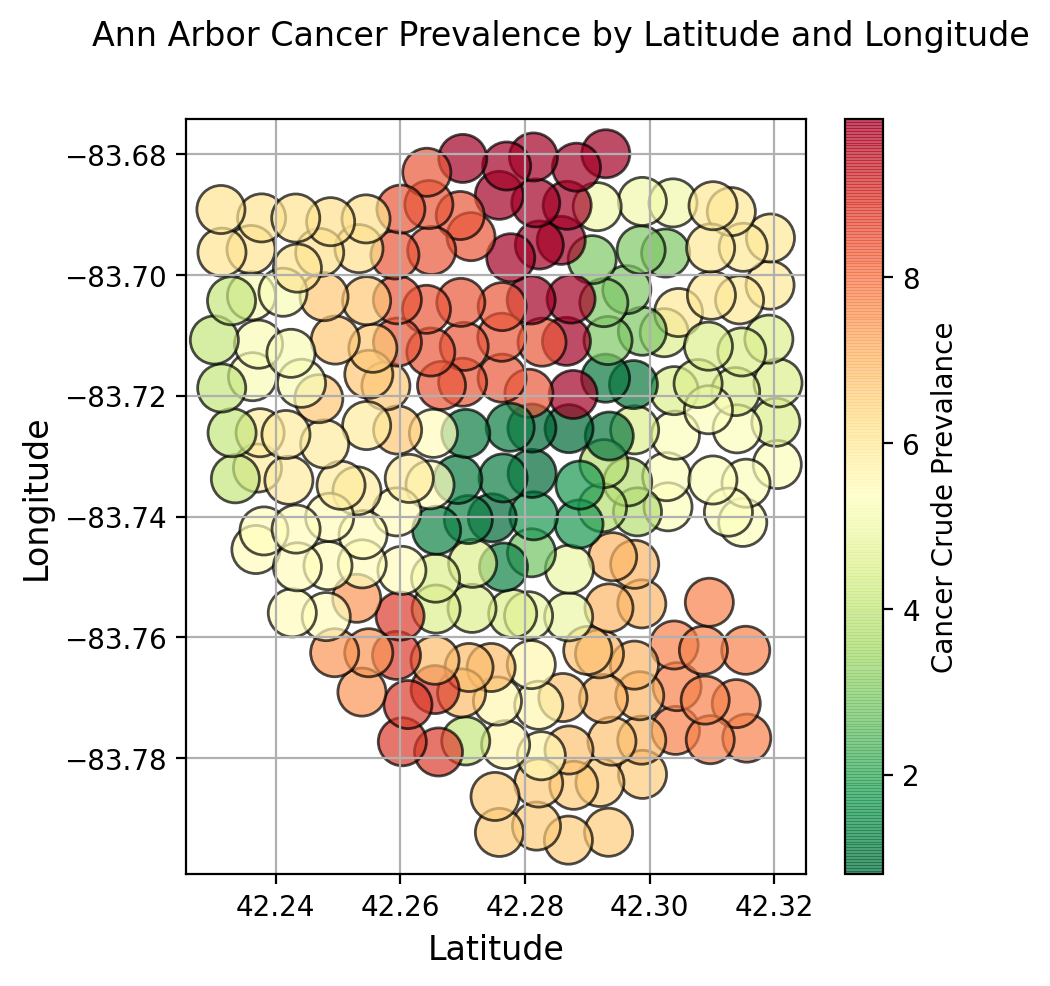

In [42]:
tmp = data_df.copy()

TITLE = 'Ann Arbor Cancer Prevalence by Latitude and Longitude'
TARGET_COL = 'CANCER_CrudePrev'

# tmp.columns.to_list()

fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="Longitude", 
                      x_lab="Latitude")

scat = plt.scatter(utils.rand_jitter(tmp['latitiude']), 
                   utils.rand_jitter(tmp['longitude']), 
                   s=300, 
                   c=tmp[TARGET_COL],
                   edgecolor='black',
                   alpha=0.7,
                   cmap='RdYlGn_r')

plt.grid()
cb = plt.colorbar(scat)
cb.set_label('Cancer Crude Prevalance')
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')
    

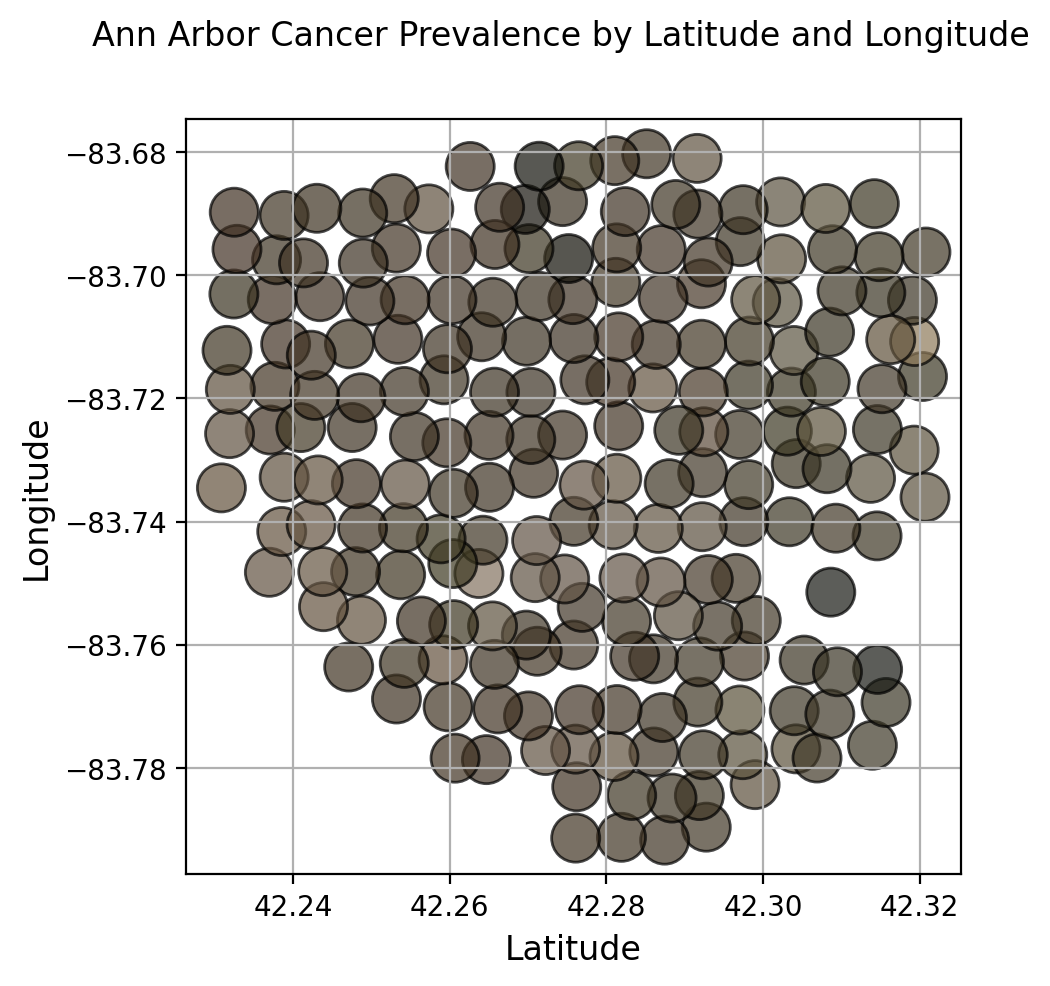

In [156]:
tmp = data_df.copy()

TITLE = 'Ann Arbor Cancer Prevalence by Latitude and Longitude'
TARGET_COL = 'COLOR_1_'

color_cols = [x for x in tmp.columns.to_list() if TARGET_COL in x and not 'score' in x and not 'fraction' in x]


tmp[color_cols] = tmp[color_cols]/255.0
tmp['normed_color'] = tuple(tmp[color_cols].values.tolist())


fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="Longitude", 
                      x_lab="Latitude")

scat = plt.scatter(utils.rand_jitter(tmp['latitiude']), 
                   utils.rand_jitter(tmp['longitude']), 
                   s=300, 
                   c=tmp['normed_color'],
                   edgecolor='black',
                   alpha=0.7,
                   cmap='RdYlGn_r')

plt.grid()
# cb = plt.colorbar(scat)
# cb.set_label('Cancer Crude Prevalance')
# save_filepath = f"../figures/{TITLE}.png"
# plt.savefig(save_filepath,  bbox_inches = 'tight')
    

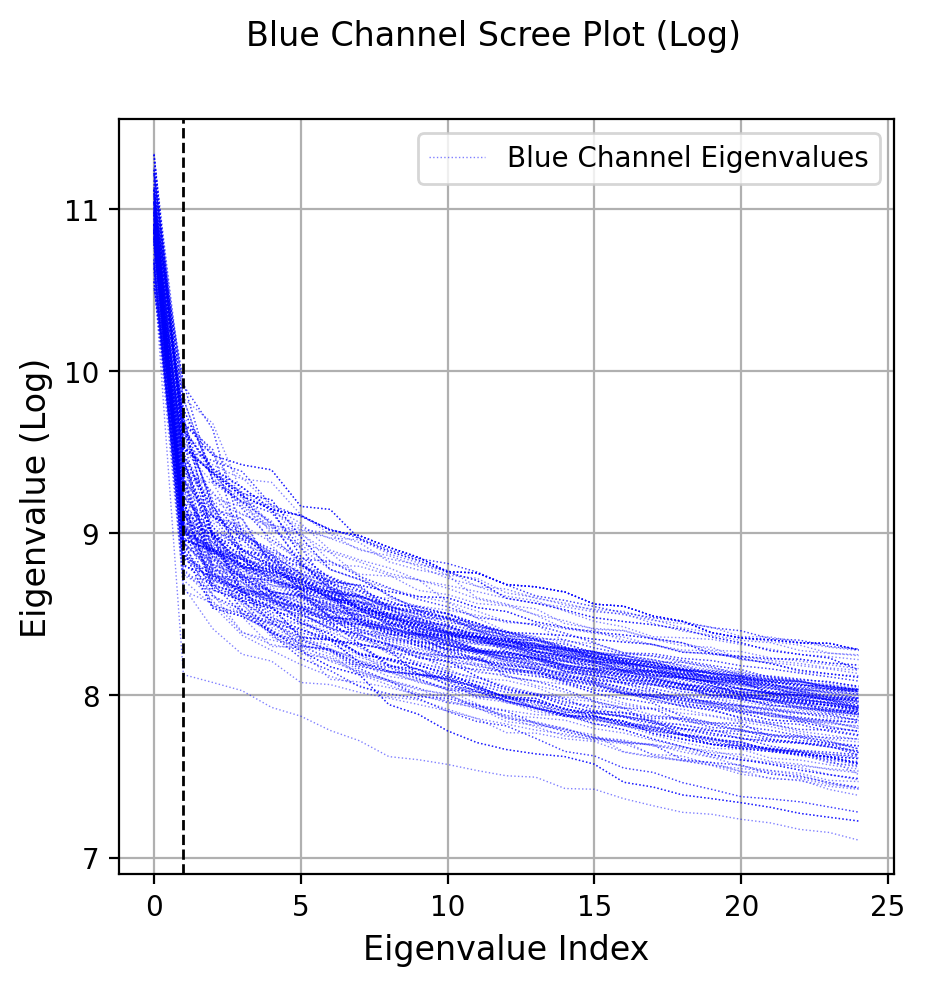

In [155]:

TITLE = 'Blue Channel Scree Plot (Log)'
SAMPLE_SIZE = len(data_df)
FIRST_N = 25

tmp = data_df.copy()

red_eig_cols = [x for x in tmp.columns if 'red_eig_' in x]
green_eig_cols = [x for x in tmp.columns if 'green_eig_' in x]
blue_eig_cols = [x for x in tmp.columns if 'blue_eig_' in x]

ind = np.array(range(len(red_eig_cols)))[:FIRST_N]


fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="Eigenvalue (Log)", 
                      x_lab="Eigenvalue Index")

for i in range(SAMPLE_SIZE):
    reds = tmp[red_eig_cols].sample(1).values.ravel()[:FIRST_N]
    greens = tmp[green_eig_cols].sample(1).values.ravel()[:FIRST_N]
    blues = tmp[blue_eig_cols].sample(1).values.ravel()[:FIRST_N]

    if i == 0:
        # plt.plot(ind, np.log(reds), c='r', ls="-", alpha=0.5,linewidth=0.5, label='Red Channel Eigenvalues')
        # plt.plot(ind, np.log(greens), c='g', ls="--", alpha=0.5, linewidth=0.5, label='Green Channel Eigenvalues')
        plt.plot(ind, np.log(blues), c='b', ls=":", alpha=0.5,linewidth=0.5, label='Blue Channel Eigenvalues')
        plt.legend()
        plt.grid()
    else:
        # plt.plot(ind, np.log(reds), c='r', ls="-",linewidth=0.5, alpha=0.2)
        # plt.plot(ind, np.log(greens), c='g', ls="--", linewidth=0.5, alpha=0.5)
        plt.plot(ind, np.log(blues), c='b', ls=":", linewidth=0.5, alpha=0.5)

plt.axvline(1, color='black', ls='--', lw=1)
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')

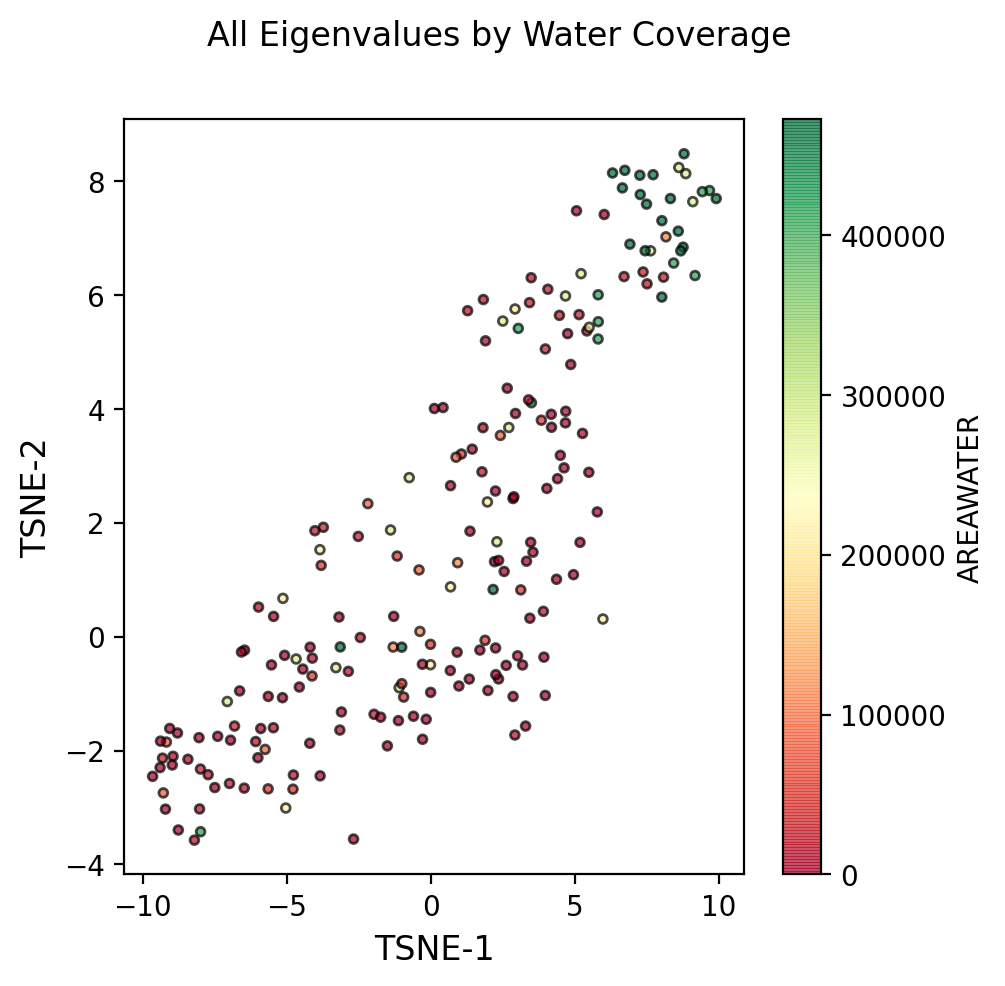

In [170]:
TITLE = 'All Eigenvalues by Water Coverage'
PERPLEXITY = 50

tmp = data_df.copy()

red_eig_cols = [x for x in tmp.columns if 'red_eig_' in x]
green_eig_cols = [x for x in tmp.columns if 'green_eig_' in x]
blue_eig_cols = [x for x in tmp.columns if 'blue_eig_' in x]

embedded = TSNE(n_components=2, 
                perplexity=PERPLEXITY).fit_transform(tmp[red_eig_cols + green_eig_cols + blue_eig_cols])

fig = utils.build_fig(title=f"{TITLE}",
                      y_lab="TSNE-2", 
                      x_lab="TSNE-1")

scat = plt.scatter(embedded[:, 0], 
                   embedded[:, 1], 
                   s=10, 
                   c=tmp['AREAWATER'],
                   alpha=0.7,
                   edgecolor='black',
                   cmap='RdYlGn')

cb = plt.colorbar(scat)
cb.set_label('AREAWATER')
save_filepath = f"../figures/{TITLE}.png"
plt.savefig(save_filepath,  bbox_inches = 'tight')

tography_score',
 'Stock_photography_score',
 'Stone_wall_score',
 'Street_score',
 'Street_light_score',
 'Suburb_score',
 'Symbol_score',
 'Syngnathiformes_score',
 'T-shirt_score',
 'Table_score',
 'Tail_score',
 'Tan_score',
 'Tank_score',
 'Tap_score',
 'Technology_score',
 'Telephone_score',
 'Temple_score',
 'Terrain_score',
 'Terrestrial_plant_score',
 'Text_score',
 'Textile_score',
 'Thermokarst_score',
 'Thoroughfare_score',
 'Tile_score',
 'Tile_flooring_score',
 'Tints_and_shades_score',
 'Tire_score',
 'Tourism_score',
 'Tourist_attraction_score',
 'Track_score',
 'Transport_score',
 'Tree_score',
 'Triumphal_arch_score',
 'Trousers_score',
 'Trunk_score',
 'Tunnel_score',
 'Turquoise_score',
 'Turtle_score',
 'Twig_score',
 'Uniform_score',
 'Urban_area_score',
 'Urban_design_score',
 'Vegetarian_food_score',
 'Vegetation_score',
 'Vehicle_score',
 'Vehicle_door_score',
 'Viaduct_score',
 'Village_score',
 'Visual_arts_score',
 'Volcanic_field_score',
 'Wall_score',
 'Wa

,GEOID,CENTLAT,AREAWATER,STATE,BASENAME,OID,LSADC,FUNCSTAT,INTPTLAT,NAME_x,OBJECTID,TRACT,CENTLON,AREALAND,INTPTLON,MTFCC,COUNTY
0,26161403800,42.309201,23464,26,4038.0,20755292672148,CT,S,42.311729,Census Tract 4038,65425,403800,-83.731929,3502562,-83.730786,G5020,161
1,26161403600,42.311312,15993,26,4036.0,20755292662213,CT,S,42.312097,Census Tract 4036,15327,403600,-83.716531,3555347,-83.714729,G5020,161
2,26161403600,42.311312,15993,26,4036.0,20755292662213,CT,S,42.312097,Census Tract 4036,15327,403600,-83.716531,3555347,-83.714729,G5020,161
3,26161403600,42.311312,15993,26,4036.0,20755292662213,CT,S,42.312097,Census Tract 4036,15327,403600,-83.716531,3555347,-83.714729,G5020,161
4,26161402700,42.313282,3385,26,4027.0,20755292665992,CT,S,42.313948,Census Tract 4027,23063,402700,-83.698595,3372270,-83.700011,G5020,161
